In [45]:
from bloqade import var, save, load
from bloqade.atom_arrangement import Chain
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
from pathlib import Path
import json


In [46]:
experiments_dir = Path.cwd() / "experiments"
if not experiments_dir.is_dir():
    experiments_dir.mkdir()

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
result_dir = experiments_dir / timestamp
result_dir.mkdir()

print(f"Results will be stored in: {result_dir}")

Results will be stored in: c:\Users\agpri\OneDrive\Documents\GitHub\yquantum24\experiments\2024-04-13_22-55-55


In [47]:
# Set basic parameters here
n_atoms = 11
lattice_spacing = 6.1
shots = 1

# Parameters for times to take measurements
# np.arange(start, end, step)   

prep_times = np.arange(0.2, 2.2, 0.2)
scar_times = np.arange(2.2, 3.99, 0.1)
run_times = np.unique(np.hstack((prep_times, scar_times)))

run_time = var("run_time")

In [48]:
quantum_scar_program = (
    Chain(n_atoms, lattice_spacing=lattice_spacing)
    # define detuning waveform
    .rydberg.detuning.uniform.piecewise_linear(
        [0.3, 1.6, 0.3], [-18.8, -18.8, 16.3, 16.3]
    )
    .piecewise_linear([0.2, 1.6], [16.3, 0.0, 0.0])
    # slice the detuning waveform
    .slice(start=0, stop=run_time)
    # define rabi waveform
    .amplitude.uniform.piecewise_linear([0.3, 1.6, 0.3], [0.0, 15.7, 15.7, 0.0])
    .piecewise_linear([0.2, 1.4, 0.2], [0, 15.7, 15.7, 0])
    # slice waveform, add padding for the linear segment
    .slice(start=0, stop=run_time - 0.065)
    # record the value of the waveform at the end of the slice to "rabi_value"
    .record("rabi_value")
    # append segment to waveform that fixes the value of the waveform to 0
    # at the end of the waveform
    .linear("rabi_value", 0, 0.065)
)

In [49]:
batch = quantum_scar_program.batch_assign(run_time=run_times)

In [50]:
# ## Run on Emulator and Hardware
# We will run the experiment on the emulator and hardware, saving the results to disk
# so that we can plot them later. for more details on where these lines of code come
# from, see the first few tutorials.

emulator_filename = str(result_dir / "emulator_results.json")

if not os.path.isfile(emulator_filename):
    emu_batch = batch.bloqade.python().run(shots, interaction_picture=True)
    save(emu_batch, emulator_filename)


In [51]:
# %% [markdown]
# ## Plotting the results
# The quantity we are interested in is the probability of the atoms being in the Z2
# state. We can get this by looking at the counts of the Z2 state in the report
# Below we define a function that will get the probability of the Z2 state for each
# time step in the experiment.

emu_batch = load(emulator_filename)

In [52]:
def get_z2_probabilities(report):
    z2_probabilities = []

    for count in report.counts():
        z2_probability = count.get("01010101010", 0) / sum(list(count.values()))
        z2_probabilities.append(z2_probability)

    return z2_probabilities

In [53]:
emu_report = emu_batch.report()

In [54]:
emu_run_times = emu_report.list_param("run_time")
emu_z2_prob = get_z2_probabilities(emu_report)

In [55]:
experiment_parameters = {
    "n_atoms": n_atoms,
    "lattice_spacing": lattice_spacing,
    "shots": shots,
}

parameters_file_path = result_dir / "parameters.json"
with open(parameters_file_path, "w") as json_file:
    json.dump(experiment_parameters, json_file)

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\agpri\AppData\Local\Temp\ipykernel_13304\238522463.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Time ($\mu s$)")


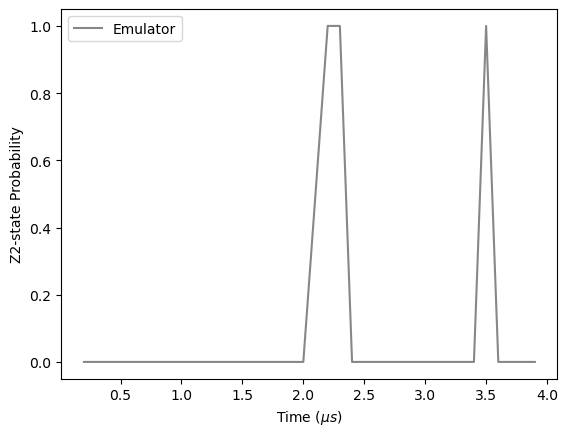

<Figure size 640x480 with 0 Axes>

In [56]:
plt.plot(emu_run_times, emu_z2_prob, label="Emulator", color="#878787")
plt.legend()
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Z2-state Probability")

plt.savefig(result_dir / "plot.png")
plt.show()
